## **[SAFE LENS 1]:** Foolbox for evasion attack

In [1]:
import torch
import foolbox as fb

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../")))
from onnxmodel.SecondModel import SecondModel

**NOTE:** In the FGSM attack, we use net.eval() to deactivate training mode, to deactivate dropout (undeterministic)

In [3]:
model = SecondModel(
    dataset_name="cifar10", batch_size=256, learning_rate=0.0003, num_epochs=60
)
model_path = os.path.join(
    os.getcwd(), "..", "..", "saved_models", "final_second_model_cifar10_60epochs.pth"
)
model.load_model(model_path)

[SAFE LENS] Dataset path: c:\Users\anaca\Documents\sexto.curso\itsec_fopra\ws24_SafeLens\data
Files already downloaded and verified


c:\Users\anaca\miniconda3\envs\secure-sight\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Dummy model built successfully.
Model loaded successfully.


In [4]:
model2 = SecondModel(
    dataset_name="imagenet", batch_size=128, learning_rate=0.0003, num_epochs=30
)
model2_path = os.path.join(
    os.getcwd(), "..", "..", "saved_models", "final_second_model_imagenet.pth"
)
model2.load_model(model2_path)

[SAFE LENS] Dataset path: c:\Users\anaca\Documents\sexto.curso\itsec_fopra\ws24_SafeLens\data
Class to index map: {'n01443537': 0, 'n01629819': 1, 'n01641577': 2, 'n01644900': 3, 'n01698640': 4, 'n01742172': 5, 'n01768244': 6, 'n01770393': 7, 'n01774384': 8, 'n01774750': 9, 'n01784675': 10, 'n01855672': 11, 'n01882714': 12, 'n01910747': 13, 'n01917289': 14, 'n01944390': 15, 'n01945685': 16, 'n01950731': 17, 'n01983481': 18, 'n01984695': 19, 'n02002724': 20, 'n02056570': 21, 'n02058221': 22, 'n02074367': 23, 'n02085620': 24, 'n02094433': 25, 'n02099601': 26, 'n02099712': 27, 'n02106662': 28, 'n02113799': 29, 'n02123045': 30, 'n02123394': 31, 'n02124075': 32, 'n02125311': 33, 'n02129165': 34, 'n02132136': 35, 'n02165456': 36, 'n02190166': 37, 'n02206856': 38, 'n02226429': 39, 'n02231487': 40, 'n02233338': 41, 'n02236044': 42, 'n02268443': 43, 'n02279972': 44, 'n02281406': 45, 'n02321529': 46, 'n02364673': 47, 'n02395406': 48, 'n02403003': 49, 'n02410509': 50, 'n02415577': 51, 'n02423022'

In [5]:
label_path = os.path.join(os.getcwd(), "..", "..", "data", "imagenet_class_index.json")

In [ ]:
import json


def edit_json_to_numeric_index(input_file: str, output_file: str) -> None:
    new_data = {}

    # If the output file already exists, do not do anything
    if os.path.exists(output_file):
        print(f"The output file already exists. Exiting.")
        return
    with open(input_file, "r") as f:
        data = json.load(f)

    # Assign numeric indices starting w/ 0
    for index, (key, value) in enumerate(data.items()):
        new_data[str(index)] = value

    with open(output_file, "w") as f:
        json.dump(new_data, f, indent=4)
    print(f"Modified JSON saved to {output_file}")


input_path = "imagenet_class_index.json"
output_path = os.path.join(
    os.getcwd(), "..", "..", "data", "modified_imagenet_class_index.json"
)
edit_json_to_numeric_index(label_path, output_path)

The output file already exists. Exiting.


### **2. EVASION ON CIFAR**

In [6]:
# In preprocessing we normalized pixels from [0, 1] to [-1, 1] which is outside the Foolbox model's bounds (0, 1).
import torch


def denormalize(inputs, dataset_name: str, return_mean_std=False) -> torch.Tensor:
    if dataset_name == "cifar10":
        mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)  # CIFAR-10 mean
        std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)  # CIFAR-10 std
    elif dataset_name == "imagenet":
        mean = torch.tensor([0.485, 0.456, 0.406]).view(
            1, 3, 1, 1
        )  # Tiny ImageNet mean
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)  # Tiny ImageNet std
    else:
        raise ValueError(f"Unknown dataset {dataset_name}")

    if return_mean_std:
        return mean, std, inputs * std + mean  # Reverse normalization
    else:
        return inputs * std + mean

## **Option 1: Evasion Attack with FGSM**

Fast Gradient Sign Method (FGSM) uses the sign of the gradient to perturb the input, i.e. computes the gradients of the loss with respect to the input image and uses the sign to create perturbations. Less effective than iterative methods.
- Perturbations are applied at inference time to fool the model into misclassifying an input.

In [7]:
def fgsm_attack(input, epsilon, data_grad):
    """
    Fast Gradient Sign Method (FGSM) attack

    Parameters:
        input (torch.Tensor): Input image
        epsilon (float): Perturbation scale
        data_grad (torch.Tensor): Gradient of the loss w.r.t the input image
    """
    sign_data_grad = data_grad.sign()  # element-wise sign of the data gradient
    perturbed_image = (
        input + epsilon * sign_data_grad
    )  # Add perturbation to the input image
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Clip to valid range
    return perturbed_image

In [8]:
import torch.nn.functional as F


def test_fgsm_attack(net, epsilon):
    correct = 0
    adv_examples = []
    processed_examples = 0
    final_acc = 0

    for inputs, labels in net.testloader:
        # Move inputs to device without denormalizing
        inputs = inputs.to(net.device)
        labels = labels.to(net.device)

        inputs.requires_grad = True

        # Original predictions with normalized inputs
        original_outputs = net.net(inputs)
        init_pred = original_outputs.max(1, keepdim=True)[1]

        # Check clean accuracy
        correct_clean = (init_pred.squeeze() == labels).sum().item()
        clean_acc = correct_clean / len(labels)
        print(f"Clean batch accuracy: {correct_clean} / {len(labels)} = {clean_acc}")

        # Compute loss
        loss = F.nll_loss(original_outputs, labels)

        # Zero all existing gradients
        net.net.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
        data_grad = inputs.grad.data

        # Generate adversarial examples (keeping normalization)
        perturbations = fgsm_attack(inputs, epsilon, data_grad)

        # Re-classify the perturbed image
        output = net.net(perturbations)

        # Get adversarial predictions
        final_pred = output.max(1, keepdim=True)[1]

        # Count correct predictions and save adversarial examples
        for i in range(len(labels)):
            processed_examples += 1
            if final_pred[i].item() == labels[i].item():
                correct += 1
                if epsilon == 0 and len(adv_examples) < 5:
                    adv_ex = inputs[i].squeeze().detach().cpu().numpy()
                    adv_examples.append(
                        (init_pred[i].item(), final_pred[i].item(), adv_ex)
                    )
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbations[i].squeeze().detach().cpu().numpy()
                    adv_examples.append(
                        (init_pred[i].item(), final_pred[i].item(), adv_ex)
                    )

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(processed_examples) if processed_examples > 0 else 0
    print(
        f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {processed_examples} = {final_acc}"
    )

    return final_acc, adv_examples

Tiny-ImageNet or other datasets require transformations like transforms.ToTensor() to convert PIL Images into Tensors. Without this, the DataLoader shows error when trying to collate PIL Images into a batch.
for inputs, labels in testloader:
    print(type(inputs))  # Should print <class 'torch.Tensor'>
    print(inputs.shape)  # Check the shape of the tensor
    break

Clean batch accuracy: 314 / 512 = 0.61328125
Clean batch accuracy: 323 / 512 = 0.630859375
Clean batch accuracy: 315 / 512 = 0.615234375
Clean batch accuracy: 313 / 512 = 0.611328125
Clean batch accuracy: 320 / 512 = 0.625
Clean batch accuracy: 313 / 512 = 0.611328125
Clean batch accuracy: 329 / 512 = 0.642578125
Clean batch accuracy: 305 / 512 = 0.595703125
Clean batch accuracy: 301 / 512 = 0.587890625
Clean batch accuracy: 306 / 512 = 0.59765625
Clean batch accuracy: 321 / 512 = 0.626953125
Clean batch accuracy: 308 / 512 = 0.6015625
Clean batch accuracy: 308 / 512 = 0.6015625
Clean batch accuracy: 286 / 512 = 0.55859375
Clean batch accuracy: 211 / 332 = 0.6355421686746988
Epsilon: 0.05	Test Accuracy = 1217 / 7500 = 0.16226666666666667
Clean batch accuracy: 320 / 512 = 0.625
Clean batch accuracy: 333 / 512 = 0.650390625
Clean batch accuracy: 304 / 512 = 0.59375
Clean batch accuracy: 311 / 512 = 0.607421875
Clean batch accuracy: 321 / 512 = 0.626953125
Clean batch accuracy: 320 / 512 

C:\Users\anaca\AppData\Local\Temp\ipykernel_14816\2219000044.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b*-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epsilons, clean_accuracies, "b*-", label="Clean Accuracy", color="blue")
C:\Users\anaca\AppData\Local\Temp\ipykernel_14816\2219000044.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


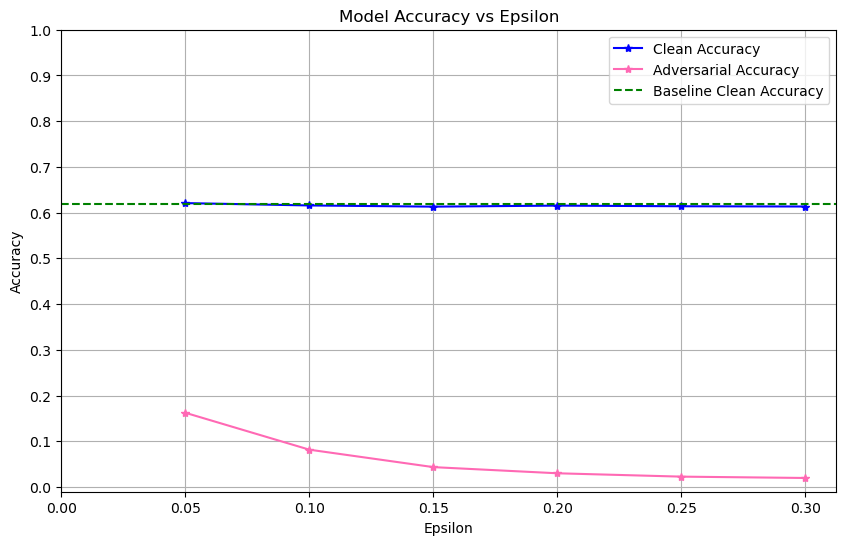

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import csv


def global_test_fgsm_attack(net, epsilons, results_csv_path) -> tuple:
    clean_accuracies = []
    adv_accuracies = []
    examples = []
    net.net.eval()

    # Get baseline clean accuracy (epsilon = 0)
    clean_acc = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in net.testloader:
            inputs, labels = inputs.to(net.device), labels.to(net.device)
            outputs = net.net(inputs)
            _, predicted = outputs.max(1)
            clean_acc += (predicted == labels).sum().item()
            total += labels.size(0)
    baseline_clean_acc = clean_acc / total

    for epsilon in epsilons:
        # Track clean accuracy for this batch
        batch_clean_acc = []
        for inputs, labels in net.testloader:
            inputs, labels = inputs.to(net.device), labels.to(net.device)
            outputs = net.net(inputs)
            _, predicted = outputs.max(1)
            acc = (predicted == labels).sum().item() / labels.size(0)
            batch_clean_acc.append(acc)

        # Average clean accuracy across batches
        avg_clean_acc = sum(batch_clean_acc) / len(batch_clean_acc)
        clean_accuracies.append(avg_clean_acc)

        # Get adversarial accuracy
        final_acc, adv_examples = test_fgsm_attack(net, epsilon)
        adv_accuracies.append(final_acc)
        examples.append(adv_examples)

    # Save results to CSV
    results_data = [["Epsilon", "Clean Accuracy", "Adversarial Accuracy", "Examples"]]
    for epsilon, clean_acc, adv_acc, ex in zip(
        epsilons, clean_accuracies, adv_accuracies, examples
    ):
        example_summary = "; ".join(
            [f"True:{e[0]}, Adversarial:{e[1]}" for e in ex[:10]]
        )
        results_data.append([epsilon, clean_acc, adv_acc, example_summary])

    with open(results_csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(results_data)

    # Plot both clean and adversarial accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, clean_accuracies, "b*-", label="Clean Accuracy", color="blue")
    plt.plot(
        epsilons, adv_accuracies, "r*-", label="Adversarial Accuracy", color="hotpink"
    )

    # Add baseline clean accuracy as horizontal line
    plt.axhline(
        y=baseline_clean_acc,
        color="green",
        linestyle="--",
        label="Baseline Clean Accuracy",
    )

    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, max(epsilons) + 0.05, step=0.05))
    plt.title("Model Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    return clean_accuracies, adv_accuracies, examples


# Test the attack
results_csv_path = "fgsm_attack_results.csv"
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
clean_accuracies, adv_accuracies, examples = global_test_fgsm_attack(
    model, epsilons, results_csv_path
)

Larger epsion introduces stronger perturbations. At small epsilon (e.g., 0.05), the attack already achieves a drop in accuracy (to 2.03%)

## **Option 2: Attack with PGD**

**Projected Gradient Descent** applies FGSM in iterations i.e. multi-step.

C:\Users\anaca\AppData\Local\Temp\ipykernel_14816\2913114300.py:97: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b*-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epsilons, clean_accuracies, "b*-", label="Clean Accuracy", color="blue")
C:\Users\anaca\AppData\Local\Temp\ipykernel_14816\2913114300.py:98: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epsilons, adv_accuracies, "r*-", label="Adversarial Accuracy", color="hotpink")


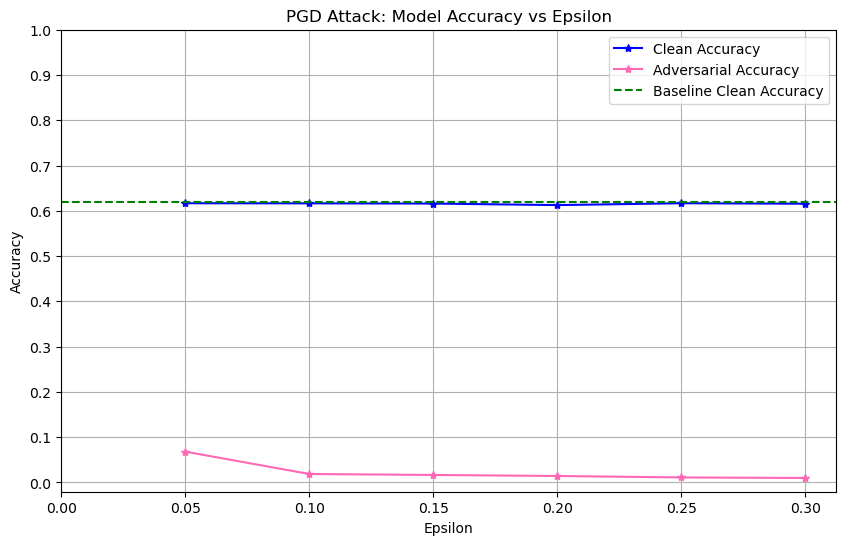

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import csv


def pgd_attack(model, inputs, labels, epsilon, alpha, iters):
    """
    Performs Projected Gradient Descent (PGD) attack on the given inputs.

    Args:
        model: The neural network model to attack.
        inputs: The input images.
        labels: The true labels corresponding to the inputs.
        epsilon: Maximum perturbation allowed.
        alpha: Step size for each iteration.
        iters: Number of attack iterations.

    Returns:
        adversarial examples (perturbed inputs).
    """
    inputs = inputs.clone().detach().to(model.device)
    labels = labels.to(model.device)
    adv_inputs = inputs.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model.net(adv_inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        adv_inputs = adv_inputs + alpha * adv_inputs.grad.sign()
        perturbation = torch.clamp(adv_inputs - inputs, min=-epsilon, max=epsilon)
        adv_inputs = (
            torch.clamp(inputs + perturbation, min=0, max=1)
            .detach()
            .requires_grad_(True)
        )

    return adv_inputs


def global_test_pgd_attack(net, epsilons, alpha, iters, results_csv_path) -> tuple:
    """
    Evaluates PGD attack across multiple epsilon values.

    Args:
        net: The trained model.
        epsilons: List of epsilon values to test.
        alpha: Step size for each PGD iteration.
        iters: Number of PGD iterations.
        results_csv_path: Path to save results as CSV.

    Returns:
        clean_accuracies, adversarial_accuracies, adversarial_examples
    """
    clean_accuracies = []
    adv_accuracies = []
    examples = []
    net.net.eval()

    # Compute clean accuracy
    clean_acc = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in net.testloader:
            inputs, labels = inputs.to(net.device), labels.to(net.device)
            outputs = net.net(inputs)
            _, predicted = outputs.max(1)
            clean_acc += (predicted == labels).sum().item()
            total += labels.size(0)
    baseline_clean_acc = clean_acc / total

    for epsilon in epsilons:
        batch_clean_acc = []
        for inputs, labels in net.testloader:
            inputs, labels = inputs.to(net.device), labels.to(net.device)
            outputs = net.net(inputs)
            _, predicted = outputs.max(1)
            batch_clean_acc.append((predicted == labels).sum().item() / labels.size(0))

        avg_clean_acc = sum(batch_clean_acc) / len(batch_clean_acc)
        clean_accuracies.append(avg_clean_acc)

        # Test PGD attack
        final_acc, adv_examples = test_pgd_attack(net, epsilon, alpha, iters)
        adv_accuracies.append(final_acc)
        examples.append(adv_examples)

    # Save results to CSV
    results_data = [["Epsilon", "Clean Accuracy", "Adversarial Accuracy", "Examples"]]
    for epsilon, clean_acc, adv_acc, ex in zip(
        epsilons, clean_accuracies, adv_accuracies, examples
    ):
        example_summary = "; ".join(
            [f"True:{e[0]}, Adversarial:{e[1]}" for e in ex[:10]]
        )
        results_data.append([epsilon, clean_acc, adv_acc, example_summary])

    with open(results_csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(results_data)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, clean_accuracies, "b*-", label="Clean Accuracy", color="blue")
    plt.plot(
        epsilons, adv_accuracies, "r*-", label="Adversarial Accuracy", color="hotpink"
    )
    plt.axhline(
        y=baseline_clean_acc,
        color="green",
        linestyle="--",
        label="Baseline Clean Accuracy",
    )

    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, max(epsilons) + 0.05, step=0.05))
    plt.title("PGD Attack: Model Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    return clean_accuracies, adv_accuracies, examples


def test_pgd_attack(net, epsilon, alpha, iters):
    """
    Runs PGD attack on the model and evaluates adversarial accuracy.

    Args:
        net: The trained model.
        epsilon: Maximum perturbation allowed.
        alpha: Step size for each PGD iteration.
        iters: Number of PGD iterations.

    Returns:
        Final adversarial accuracy, list of adversarial examples.
    """
    correct = 0
    total = 0
    adv_examples = []

    for inputs, labels in net.testloader:
        inputs, labels = inputs.to(net.device), labels.to(net.device)
        adv_inputs = pgd_attack(net, inputs, labels, epsilon, alpha, iters)
        outputs = net.net(adv_inputs)
        _, predicted = outputs.max(1)  # Get predictions

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Store first few adversarial examples
        if len(adv_examples) < 5:
            for i in range(min(5, labels.size(0))):  # Avoid exceeding batch size
                adv_examples.append((labels[i].item(), predicted[i].item()))

    final_acc = correct / total
    return final_acc, adv_examples


# Test the attack
results_csv_path = "pgd_attack_results.csv"
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
alpha = 0.01  # Step size
iters = 10  # Number of iterations

clean_accuracies, adv_accuracies, examples = global_test_pgd_attack(
    model, epsilons, alpha, iters, results_csv_path
)